In [1]:
# %load test_dagm2007.py
import os
from PIL import Image

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

from dagmm import DAGMM

import matplotlib.pyplot as plt

root = '/home/genta/dataset/DAGM2007/Class1/'
fnames = os.listdir(root)
np_imgs = []

for fname in fnames:
    im = Image.open(os.path.join(root, fname))
    np_imgs.append(np.asarray(im))
np_imgs = np.asarray(np_imgs)
np_imgs = np_imgs.astype(np.float64)

np_imgs_mean = np_imgs.mean(axis=0)
np_imgs_var = np_imgs.var(axis=0)
np_imgs = (np_imgs - np_imgs_mean) / np.sqrt(np_imgs_var)
np_imgs = np_imgs.astype(np.float64)

np_imgs = np_imgs.reshape(-1, 512*512)

In [2]:
rnd_seeds = np.random.permutation(10)

In [3]:
rnd_seeds

array([2, 9, 1, 6, 8, 7, 0, 4, 3, 5])

In [4]:
x_train = np_imgs[:len(np_imgs)//2]
x_test = np_imgs[len(np_imgs)//2:len(np_imgs)//2+100]
np.random.seed(rnd_seeds[0])
x_test[:5] = np.random.rand(*x_test[:5].shape) + x_train.mean()

In [29]:
test_labels = np.zeros(len(x_test))
test_labels[:5] = 1

# PyTorchのヤツと同じアーキテクチャ

In [7]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60, 30, 10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 4], est_activation=tf.nn.tanh, est_dropout_ratio=0.5,
    learning_rate=0.0001, epoch_size=200, minibatch_size=200
)


print('train size', len(x_train))
model_dagmm.fit(x_train)

train size 500
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)
<class 'tensorflow.python.framework.tensor_shape.Dimension'>
Tensor("GMM/truediv_1:0", shape=(4, 3, 3), dtype=float32)
Tensor("GMM/mul_3:0", shape=(3, 3), dtype=float32)
Tensor("GMM_energy/Log_2:0", shape=(4, 1), dtype=float32)
Tensor("GMM_energy/mul_2:0", shape=(4, ?), dtype=float32)
Tensor("GMM_energy/mul_1:0", shape=(), dtype=float32)
Tensor("GMM_energy/strided_slice_3:0", shape=(4, 1), dtype=float32)
 epoch 100/200 : loss = 264050.062
 epoch 200/200 : loss = 263606.031
Tensor("GMM_energy_1/Log_2:0", shape=(4, 1), dtype=float32)
Tensor("GMM_energy_1/mul_2:0", shape=(4, ?), dtype=float32)
Tensor("GMM_energy_1/mul_1:0", shape=(), dtype=float32)
Tensor("GMM_energy_1/strided_slice_3:0", shape=(4, 1), dtype=float32)
CPU times: user 1min 21s, sys: 40.9 s, total: 2min 2s
Wall time: 2min 17s


(100,)


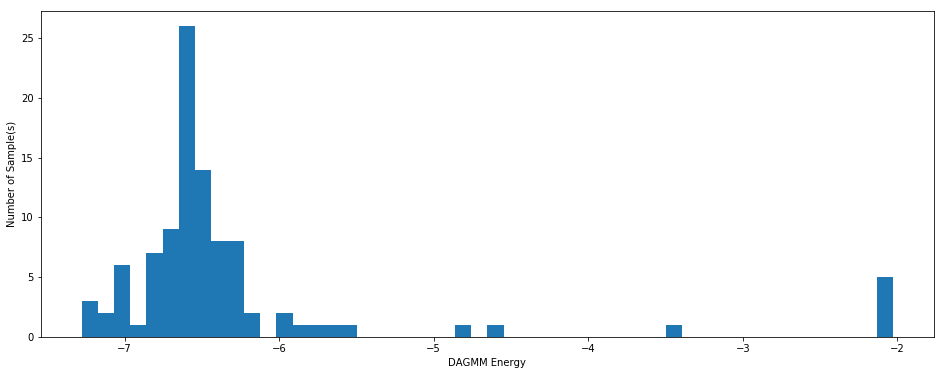

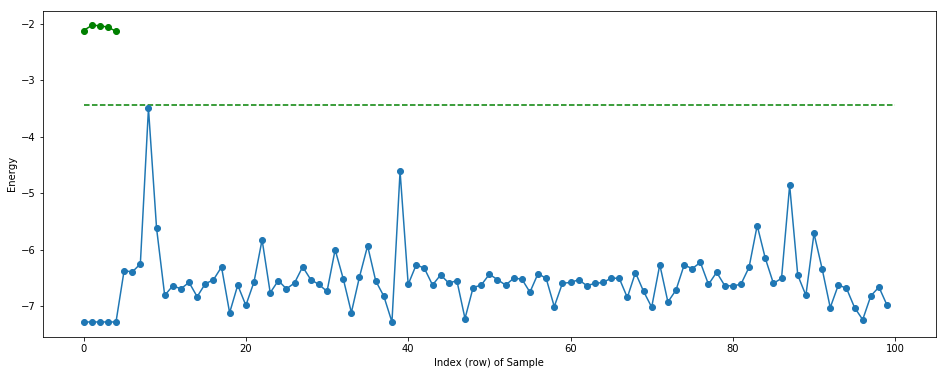

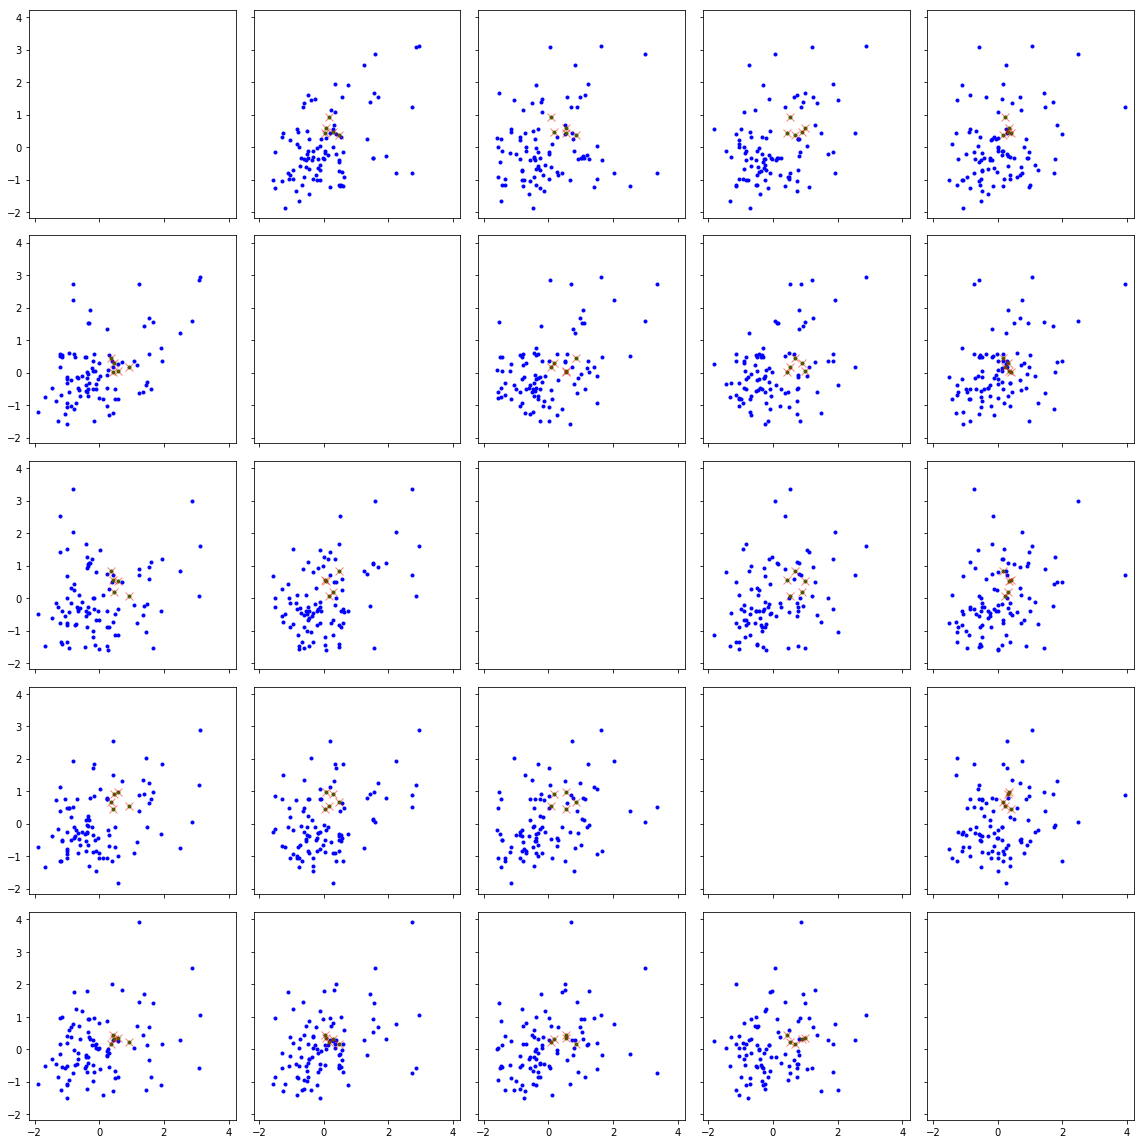

In [9]:
data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(5)*energy[5:].min(), energy[5:]]), "o-")
plt.plot(energy[:5], "o-", c='g')
plt.hlines(np.percentile(energy, 95), 0, 100, 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[5:,col], data[5:,row], ".", c='b')
            ax.plot(data[:5,col], data[:5,row], ".", c='g')
            ano_index = np.arange(len(energy))[energy > np.percentile(energy, 95)]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()


In [32]:
train_energy = model_dagmm.predict(x_train)
test_energy =  model_dagmm.predict(x_test)

combined_energy = np.concatenate((train_energy, test_energy), 0)

thresh = np.percentile(combined_energy, 100 - 5/600*100)
print("Threshold :", thresh)

# 逆
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Threshold : -2.0586543480555215
Accuracy : 0.9700, Precision : 1.0000, Recall : 0.4000, F-score : 0.5714


In [33]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60, 30, 10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 4], est_activation=tf.nn.tanh, est_dropout_ratio=0.5,
    learning_rate=0.0001, epoch_size=200, minibatch_size=2
)


print('train size', len(x_train))
model_dagmm.fit(x_train)

train size 500
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)
<class 'tensorflow.python.framework.tensor_shape.Dimension'>
Tensor("GMM/truediv_1:0", shape=(4, 3, 3), dtype=float32)
Tensor("GMM/mul_3:0", shape=(3, 3), dtype=float32)
Tensor("GMM_energy/Log_2:0", shape=(4, 1), dtype=float32)
Tensor("GMM_energy/mul_2:0", shape=(4, ?), dtype=float32)
Tensor("GMM_energy/mul_1:0", shape=(), dtype=float32)
Tensor("GMM_energy/strided_slice_3:0", shape=(4, 1), dtype=float32)
 epoch 100/200 : loss = 263062.625
 epoch 200/200 : loss = 263851.906
Tensor("GMM_energy_1/Log_2:0", shape=(4, 1), dtype=float32)
Tensor("GMM_energy_1/mul_2:0", shape=(4, ?), dtype=float32)
Tensor("GMM_energy_1/mul_1:0", shape=(), dtype=float32)
Tensor("GMM_energy_1/strided_slice_3:0", shape=(4, 1), dtype=float32)
CPU times: user 24min 40s, sys: 16min 36s, total: 41min 16s
Wall time: 56min 39s


(100,)


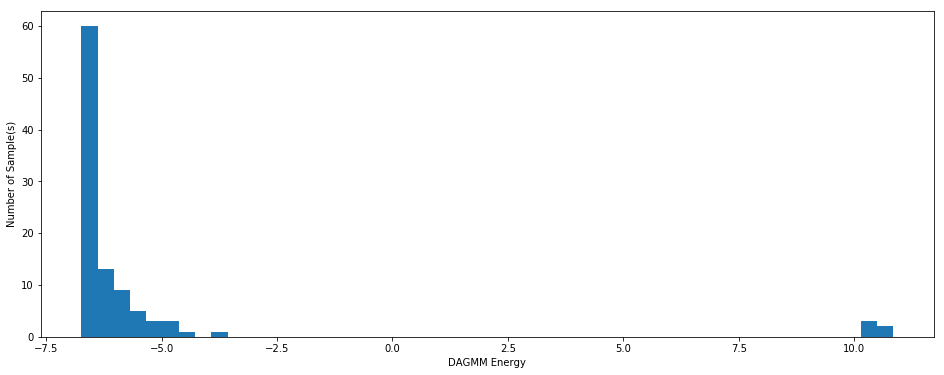

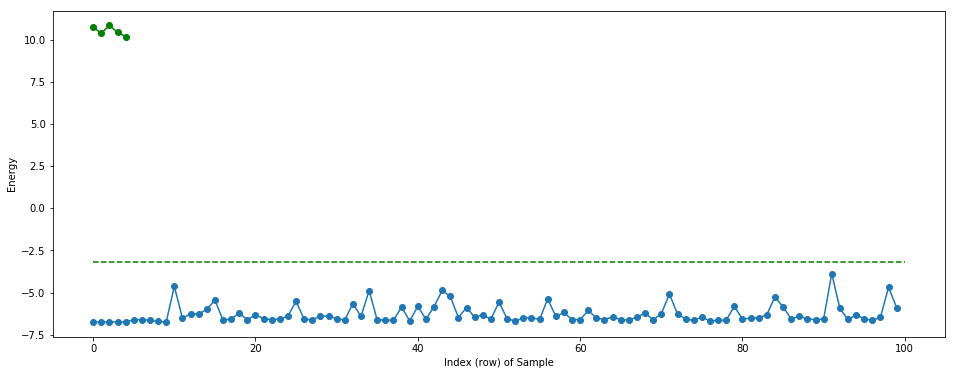

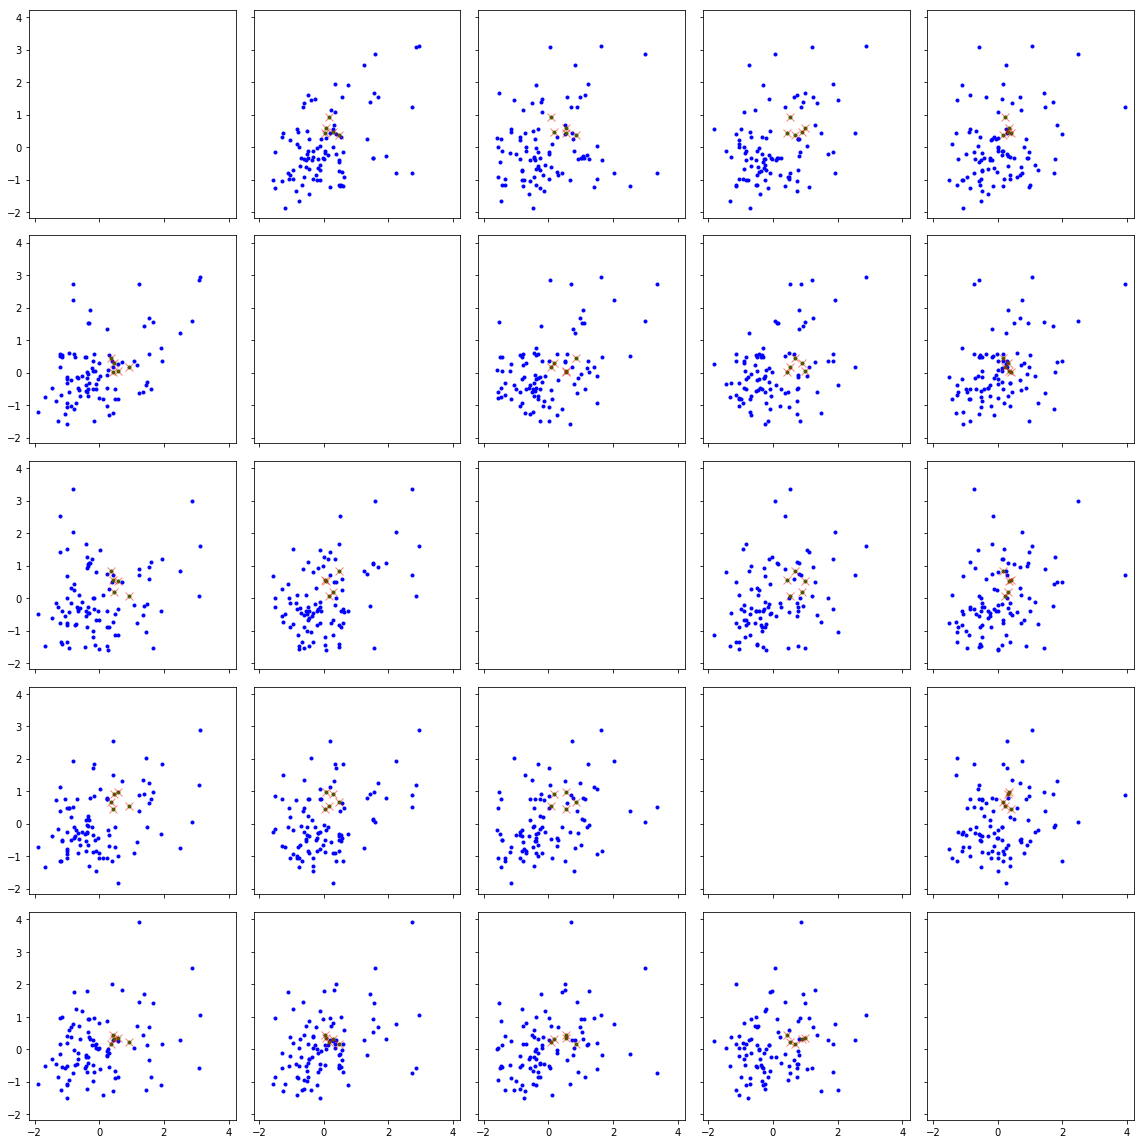

In [36]:
data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(5)*energy[5:].min(), energy[5:]]), "o-")
plt.plot(energy[:5], "o-", c='g')
plt.hlines(np.percentile(energy, 95), 0, 100, 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[5:,col], data[5:,row], ".", c='b')
            ax.plot(data[:5,col], data[:5,row], ".", c='g')
            ano_index = np.arange(len(energy))[energy > np.percentile(energy, 95)]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()


In [37]:
train_energy = model_dagmm.predict(x_train)
test_energy =  model_dagmm.predict(x_test)

combined_energy = np.concatenate((train_energy, test_energy), 0)

thresh = np.percentile(combined_energy, 100 - 5/600*100)
print("Threshold :", thresh)

# 逆
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Threshold : 10.745177920659383
Accuracy : 0.9600, Precision : 1.0000, Recall : 0.2000, F-score : 0.3333


# minibatch size が１だとうまくいかない

In [38]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60, 30, 10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 4], est_activation=tf.nn.tanh, est_dropout_ratio=0.5,
    learning_rate=0.0001, epoch_size=100, minibatch_size=1
)


print('train size', len(x_train))
model_dagmm.fit(x_train)

train size 500
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)
<class 'tensorflow.python.framework.tensor_shape.Dimension'>
Tensor("GMM/truediv_1:0", shape=(4, 3, 3), dtype=float32)
Tensor("GMM/mul_3:0", shape=(3, 3), dtype=float32)
Tensor("GMM_energy/Log_2:0", shape=(4, 1), dtype=float32)
Tensor("GMM_energy/mul_2:0", shape=(4, ?), dtype=float32)
Tensor("GMM_energy/mul_1:0", shape=(), dtype=float32)
Tensor("GMM_energy/strided_slice_3:0", shape=(4, 1), dtype=float32)


InvalidArgumentError: Got info = 1 for batch index 0, expected info = 0. Debug_info =potrf
	 [[Node: GMM/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](GMM/add)]]
	 [[Node: gradients/AddN_1/_41 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_918_gradients/AddN_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'GMM/Cholesky', defined at:
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-eba5585b0629>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "\nmodel_dagmm = DAGMM(\n    comp_hiddens=[60, 30, 10, 1], comp_activation=tf.nn.tanh,\n    est_hiddens=[10, 4], est_activation=tf.nn.tanh, est_dropout_ratio=0.5,\n    learning_rate=0.0001, epoch_size=100, minibatch_size=1\n)\n\n\nprint('train size', len(x_train))\nmodel_dagmm.fit(x_train)\n")
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "</home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/decorator.py:decorator-gen-62>", line 2, in time
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 10, in <module>
  File "/home/genta/github/DAGMM/dagmm/dagmm.py", line 122, in fit
    self.gmm.fit(z, gamma, input)
  File "/home/genta/github/DAGMM/dagmm/gmm.py", line 69, in fit
    self.L = tf.cholesky(sigma + min_vals[None,:,:])
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 227, in cholesky
    result = _op_def_lib.apply_op("Cholesky", input=input, name=name)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/genta/.pyenv/versions/anaconda-4.0.0/envs/tensorflow-1.2.0/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Got info = 1 for batch index 0, expected info = 0. Debug_info =potrf
	 [[Node: GMM/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](GMM/add)]]
	 [[Node: gradients/AddN_1/_41 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_918_gradients/AddN_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [39]:
data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(5)*energy[5:].min(), energy[5:]]), "o-")
plt.plot(energy[:5], "o-", c='g')
plt.hlines(np.percentile(energy, 95), 0, 100, 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[5:,col], data[5:,row], ".", c='b')
            ax.plot(data[:5,col], data[:5,row], ".", c='g')
            ano_index = np.arange(len(energy))[energy > np.percentile(energy, 95)]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()


AttributeError: 'DAGMM' object has no attribute 'energy'

In [37]:
train_energy = model_dagmm.predict(x_train)
test_energy =  model_dagmm.predict(x_test)

combined_energy = np.concatenate((train_energy, test_energy), 0)

thresh = np.percentile(combined_energy, 100 - 5/600*100)
print("Threshold :", thresh)

# 逆
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Threshold : 10.745177920659383
Accuracy : 0.9600, Precision : 1.0000, Recall : 0.2000, F-score : 0.3333
